# Proportion Tests

# 1. One-sample proportion tests

<b>1.1 t for proportions?</b>

Some of the hypothesis tests in this course have used a  test statistic <i>z</i> and some have used a <i>t</i> test statistic. To get the correct p-value, you need to use the right type of test statistic.

Do tests of proportion(s) use a  or a  test statistic and why?

- <i>t</i> : There are two estimates used for unknown values in the test statistic for proportion(s).

- <i>z</i> : Since the population standard deviation is always known for proportions, we always compute z-scores.

- <b><font color='green'><i>z</i> : The test statistic for proportion(s) has only one estimate of a parameter instead of two.</font></b>

- <i>t</i> : Proportions are ratios, so you need to estimate the numerator and the denominator.

The t-test is needed for tests of mean(s) since you are estimating two unknown quantities, which leads to more variability.

<b>1.2 Test for single proportions</b>

In Chapter 1, you calculated a p-value for a test hypothesizing that the proportion of late shipments was greater than 6%. In that chapter, you used a bootstrap distribution to estimate the standard error of the statistic. An alternative is to use an equation for the standard error based on the sample proportion, hypothesized proportion, and sample size.

$$
z = \frac{\hat{p}-p_{o}}{\sqrt{\frac{p_{o}*(1-p_{o})}{n}}}
$$

In [481]:
# Import the late_shipment dataframe
import pandas as pd
import numpy as np

late_shipments = pd.read_feather("C:\\Users\\yazan\\Desktop\\Data_Analytics\\9-Introduction to Hypothesis Testing\\Datasets\\late_shipments.feather")
print(late_shipments.head())

        id       country managed_by  fulfill_via vendor_inco_term  \
0  36203.0       Nigeria   PMO - US  Direct Drop              EXW   
1  30998.0      Botswana   PMO - US  Direct Drop              EXW   
2  69871.0       Vietnam   PMO - US  Direct Drop              EXW   
3  17648.0  South Africa   PMO - US  Direct Drop              DDP   
4   5647.0        Uganda   PMO - US  Direct Drop              EXW   

  shipment_mode  late_delivery late product_group    sub_classification  ...  \
0           Air            1.0  Yes          HRDT              HIV test  ...   
1           Air            0.0   No          HRDT              HIV test  ...   
2           Air            0.0   No           ARV                 Adult  ...   
3         Ocean            0.0   No           ARV                 Adult  ...   
4           Air            0.0   No          HRDT  HIV test - Ancillary  ...   

  line_item_quantity line_item_value pack_price unit_price  \
0             2996.0       266644.00      

In [482]:
from scipy.stats import norm

# Hypothesize that the proportion of late shipments is 6%
p_0 = 0.06

# Calculate the sample proportion of late shipments
p_hat = (late_shipments['late'] == "Yes").mean()

# Calculate the sample size
n = len(late_shipments)

# Calculate the numerator and denominator of the test statistic
numerator = p_hat - p_0
denominator = np.sqrt(p_0 * (1 - p_0) / n)

# Calculate the test statistic
z_score = numerator / denominator

# Calculate the p-value from the z-score
p_value = 1 - norm.cdf(z_score)

# Print the p-value
print(p_value)

0.44703503936503364


While bootstrapping can be used to estimate the standard error of any statistic, it is computationally intensive. For proportions, using a simple equation of the hypothesized proportion and sample size is easier to compute.

# 2. Two-sample proportion test

<b>2.1 Test of two proportions</b>

You may wonder if the amount paid for freight affects whether or not the shipment was late. Recall that in the late_shipments dataset, whether or not the shipment was late is stored in the late column. Freight costs are stored in the freight_cost_group column, and the categories are "expensive" and "reasonable".

The hypotheses to test, with "late" corresponding to the proportion of late shipments for that group, are

<i>H<sub>o</suc></i> : <i>late<sub>expensive</suc></i> - <i>late<sub>resonable</suc></i> = 0

<i>H<sub>A</suc></i> : <i>late<sub>expensive</suc></i> - <i>late<sub>resonable</suc></i> > 0

p_hats contains the estimates of population proportions (sample proportions) for each freight_cost_group:

```python:
freight_cost_group  late
expensive           Yes     0.082569
reasonable          Yes     0.035165
Name: late, dtype: float64
```
ns contains the sample sizes for these groups:

```python:
freight_cost_group
expensive     545
reasonable    455
Name: late, dtype: int64
```

In [483]:
p_hats = late_shipments.groupby('freight_cost_groups')['late'].value_counts(normalize = True)
print(p_hats)

ns = late_shipments.groupby('freight_cost_groups')['late'].count()
print(ns)

freight_cost_groups  late
expensive            No      0.920904
                     Yes     0.079096
reasonable           No      0.964835
                     Yes     0.035165
Name: late, dtype: float64
freight_cost_groups
expensive     531
reasonable    455
Name: late, dtype: int64


In [484]:
# Calculate the pooled estimate of the population proportion
p_hat = (p_hats[("reasonable", "Yes")] * ns["reasonable"] + p_hats[("expensive", "Yes")] * ns["expensive"]) / (ns["reasonable"] + ns["expensive"])

# Calculate p_hat one minus p_hat
p_hat_times_not_p_hat = p_hat * (1 - p_hat)

# Divide this by each of the sample sizes and then sum
p_hat_times_not_p_hat_over_ns = p_hat_times_not_p_hat / ns["expensive"] + p_hat_times_not_p_hat / ns["reasonable"]

# Calculate the standard error
std_error = np.sqrt(p_hat_times_not_p_hat_over_ns)

# Calculate the z-score
z_score = (p_hats[('expensive', 'Yes')] - p_hats[('reasonable', 'Yes')]) / std_error
print('z_score = ',z_score)

# Calculate the p-value from the z-score
p_value = 1-norm.cdf(z_score)

# Print p_value
print('p_value = ', p_value)

z_score =  2.922648567784529
p_value =  0.0017353400023595311


You can calculate a p-value for a two sample proportion test using (a rather exhausting amount of) arithmetic. This tiny p-value leads us to suspect there is a larger proportion of late shipments for expensive freight compared to reasonable freight.

<b>2.2 proportions_ztest() for two samples</b>

That took a lot of effort to calculate the p-value, so while it is useful to see how the calculations work, it isn't practical to do in real-world analyses. For daily usage, it's better to use the statsmodels package.

Recall the hypotheses.

<i>H<sub>o</suc></i> : <i>late<sub>expensive</suc></i> - <i>late<sub>resonable</suc></i> = 0

<i>H<sub>A</suc></i> : <i>late<sub>expensive</suc></i> - <i>late<sub>resonable</suc></i> > 0

In [485]:
# Count the late column values for each freight_cost_group
late_by_freight_cost_group = late_shipments.groupby("freight_cost_groups")['late'].value_counts()

# Create an array of the "Yes" counts for each freight_cost_group
success_counts = np.array([45, 16])

# Create an array of the total number of rows in each freight_cost_group
n = np.array([45 + 500, 16 + 439])

# Run a z-test on the two proportions
from statsmodels.stats.proportion import proportions_ztest
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative='larger')

# Print the results
print(stat, p_value)

3.1190401865206128 0.0009072060637051224


statsmodels's .proportions_ztest() method gives the same results with less effort.

# 3. Chi-square test of independence

<b>3.1 The chi-square distribution</b>

Chi-square hypothesis tests rely on the chi-square distribution. Like the t-distribution, it has degrees of freedom and non-centrality parameters.

The plots show the PDF and CDF for a chi-square distribution (solid black line), and for comparison show a normal distribution with the same mean and variance (gray dotted line).

![Alt text](a.png)

![Alt text](b.png)

![Alt text](c.png)

<b>Question</b>

Which statement about the chi-square distribution is true?

- Like the normal distribution, the chi-square distribution is defined for x values from minus infinity to infinity.

- <b><font color ='green'>As you increase the degrees of freedom or the non-centrality, the chi-square distribution PDF and CDF curves get closer to those of a normal distribution.</font></b>

- As you decrease the degrees of freedom or the non-centrality, the chi-square distribution PDF and CDF curves get closer to those of a normal distribution.

- The chi-square distribution PDF is symmetric about its peak.


Like the t-distribution, the chi-square distribution has degrees of freedom and non-centrality parameters. When these numbers are large, the chi-square distribution can be approximated by a normal distribution.

<b>3.2 How many tails for chi-square tests?</b>

Unlike pingouin.ttest() and statsmodels.stats.proportion.proportions_ztest(), pingouin.chi2_independence() does not have an alternative argument to specify which tails are considered by the alternative hypothesis.

Which tail is almost always considered in chi-square tests?

Possible Answers

- Left-tailed

- <b><font color = 'green'>Right-tailed</font></b>

- Two-tailed

- Neither: chi-square tests depend on the peak, not the tails

- It depends on the problem


The chi-square test statistic is a square number, so it is always non-negative, so only the right tail tends to be of interest.

<b>3.3 Performing a chi-square test</b>

The chi-square independence test compares proportions of successes of one categorical variable across the categories of another categorical variable.

Trade deals often use a form of business shorthand in order to specify the exact details of their contract. These are International Chamber of Commerce (ICC) international commercial terms, or incoterms for short.

The late_shipments dataset includes a vendor_inco_term that describes the incoterms that applied to a given shipment. The choices are:

- EXW: "Ex works". The buyer pays for transportation of the goods.
- CIP: "Carriage and insurance paid to". The seller pays for freight and insurance until the goods board a ship.
- DDP: "Delivered duty paid". The seller pays for transportation of the goods until they reach a destination port.
- FCA: "Free carrier". The seller pays for transportation of the goods.

Perhaps the incoterms affect whether or not the freight costs are expensive. Test these hypotheses with a significance level of 0.01.

<i>H<sub>o</sub></i> : vendor_inco_term and freight_cost_group are independent.

<i>H<sub>A</sub></i> : vendor_inco_term and freight_cost_group are associated.

vendor_inco_term  freight_cost_groups
CIP               reasonable             0.680000
                  expensive              0.320000
DDP               expensive              0.550000
                  reasonable             0.450000
DDU               reasonable             1.000000
EXW               expensive              0.583448
                  reasonable             0.416552
FCA               reasonable             0.663636
                  expensive              0.336364
Name: freight_cost_groups, dtype: float64
freight_cost_groups  expensive  reasonable
vendor_inco_term                          
CIP                   0.320000    0.680000
DDP                   0.550000    0.450000
DDU                        NaN    1.000000
EXW                   0.583448    0.416552
FCA                   0.336364    0.663636


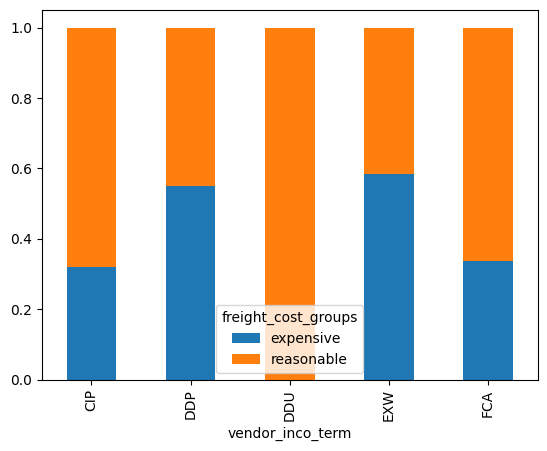

      test  lambda       chi2  dof          pval    cramer     power
0  pearson     1.0  34.805072  4.0  5.093922e-07  0.186561  0.999235


C:\Users\yazan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pingouin\contingency.py:150: UserWarning: Low count on observed frequencies.
  warnings.warn("Low count on {} frequencies.".format(name))
C:\Users\yazan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pingouin\contingency.py:150: UserWarning: Low count on expected frequencies.
  warnings.warn("Low count on {} frequencies.".format(name))
C:\Users\yazan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:7175: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\yazan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:7175: Runti

In [486]:
'''Calculate the proportion of freight_cost_group in late_shipments grouped by vendor_inco_term.'''
import pingouin
import matplotlib.pyplot as plt

# Proportion of freight_cost_group grouped by vendor_inco_term
props = late_shipments.groupby('vendor_inco_term')['freight_cost_groups'].value_counts(normalize=True)
print(props)

'''Unstack the .value_counts() result to be in wide format instead of long.'''
# Convert props to wide format
wide_props = props.unstack()
print(wide_props)

'''Create a proportional stacked bar plot with bars filled based on freight_cost_group 
across the levels of vendor_inco_term.'''
# Proportional stacked bar plot of freight_cost_group vs. vendor_inco_term
wide_props.plot(kind="bar", stacked=True)
plt.show()

'''Perform a chi-square test of independence on freight_cost_group and 
vendor_inco_term in the late_shipments dataset.'''
# Determine if freight_cost_group and vendor_inco_term are independent
expected, observed, stats = pingouin.chi2_independence(data=late_shipments, x="vendor_inco_term", y="freight_cost_groups")

# Print results
print(stats[stats['test'] == 'pearson']) 

<b>Question</b>

What should you conclude from the hypothesis test?

Possible Answers

- Fail to reject the null hypothesis and conclude that vendor_inco_term and freight_cost_group are independent.

- Reject the null hypothesis and conclude that vendor_inco_term and freight_cost_group are independent.

- Fail to reject the null hypothesis and conclude that vendor_inco_term and freight_cost_group are associated.

- <b><font color = 'green'>Reject the null hypothesis and conclude that vendor_inco_term and freight_cost_group are associated</font></b>

The test to compare proportions of successes in a categorical variable across groups of another categorical variable is called a chi-square test of independence.

# 4. Chi-square goodness of fit tests

<b>4.1 Visualizing goodness of fit</b>

The chi-square goodness of fit test compares proportions of each level of a categorical variable to hypothesized values. Before running such a test, it can be helpful to visually compare the distribution in the sample to the hypothesized distribution.

Recall the vendor incoterms in the late_shipments dataset. You hypothesize that the four values occur with these frequencies in the population of shipments.

- CIP: 0.05
- DDP: 0.1
- EXW: 0.75
- FCA: 0.1

These frequencies are stored in the hypothesized DataFrame.

The incoterm_counts DataFrame stores the .value_counts() of the vendor_inco_term column.

In [487]:
late_shipments = pd.read_feather("C:\\Users\\yazan\\Desktop\\Data_Analytics\\9-Introduction to Hypothesis Testing\\Datasets\\late_shipments.feather")
# condition = late_shipments['vendor_inco_term']=='DDP'
# late_shipments = late_shipments.drop(condition, inplace=True)
# print(late_shipments)

hypothesized_dict = {'vendor_inco_term':["CIP", "DDP", "EXW", "FCA"], "prop":[0.05, 0.1, 0.75, 0.1]}
hypothesized = pd.DataFrame(hypothesized_dict)
print(hypothesized)

incoterm = late_shipments['vendor_inco_term'].value_counts()
incoterm_counts = incoterm.rename_axis('vendor_inco_term').reset_index(name = 'n').sort_values('vendor_inco_term')
incoterm_counts = incoterm_counts.drop(index=4)
print(incoterm_counts)

  vendor_inco_term  prop
0              CIP  0.05
1              DDP  0.10
2              EXW  0.75
3              FCA  0.10
  vendor_inco_term    n
3              CIP   56
2              DDP  100
0              EXW  732
1              FCA  111


1000
  vendor_inco_term  prop      n
0              CIP  0.05   50.0
1              DDP  0.10  100.0
2              EXW  0.75  750.0
3              FCA  0.10  100.0


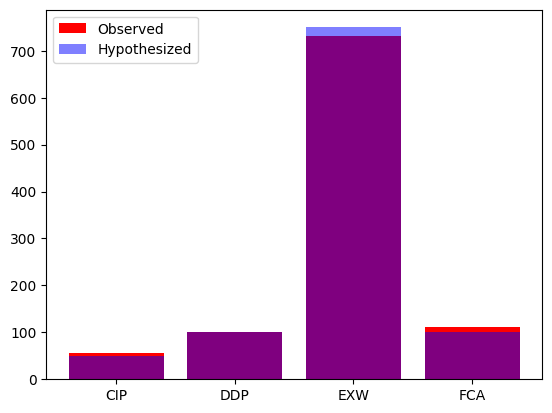

In [488]:
'''Find the total number of rows in late_shipments.'''
# Find the number of rows in late_shipments
n_total = len(late_shipments)

# Print n_total
print(n_total)

'''Add a column named n to the hypothesized DataFrame that is the hypothesized prop column times n_total.'''
# Create n column that is prop column * n_total
hypothesized['n'] = hypothesized['prop'] * n_total

# Print the modified hypothesized DataFrame
print(hypothesized)

'''Create a bar graph of 'n' versus 'vendor_inco_term' for the incoterm_counts data, specifying a red color.'''
# Plot a red bar graph of n vs. vendor_inco_term for incoterm_counts
plt.bar(incoterm_counts['vendor_inco_term'], incoterm_counts['n'], color="red", label="Observed")

# Add a blue bar plot for the hypothesized counts
plt.bar(hypothesized['vendor_inco_term'], hypothesized['n'], color = 'blue', alpha=0.5, label="Hypothesized")
plt.legend()
plt.show()

Two of the bars in the sample are very close to the hypothesized values: one is a little high and one is a little low. Head on over to the next exercise to test if these differences are statistically significant.

<b>4.2 Performing a goodness of fit test</b>

The bar plot of vendor_inco_term suggests that the distribution across the four categories was quite close to the hypothesized distribution. You'll need to perform a chi-square goodness of fit test to see whether the differences are statistically significant.

Recall the hypotheses for this type of test:

<i>H<sub>o</sub></i> : The sample matches with the hypothesized distribution.

<i>H<sub>A</sub></i> : The sample does not match with the hypothesized distribution.

To decide which hypothesis to choose, we'll set a significance level of 0.1.

In [489]:
# Perform a goodness of fit test on the incoterm counts n
from scipy.stats import chisquare
gof_test = chisquare(f_obs=incoterm_counts['n'], f_exp=hypothesized['n'])

# Print gof_test results
print(gof_test)

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.001001001001001001

<b>Question</b>

What should you conclude from the hypothesis test?

Possible Answers

- Reject the null hypothesis and conclude that n follows the distribution specified by hypothesized.

- Fail to reject the null hypothesis and conclude that n does not follow the distribution specified by hypothesized.

- Reject the null hypothesis and conclude that n does not follow the distribution specified by hypothesized.

- <b><font color='green'>Fail to reject the null hypothesis and conclude that n follows the distribution specified by hypothesized.</font></b>

The test to compare the proportions of a categorical variable to a hypothesized distribution is called a chi-square goodness of fit test.